<a href="https://colab.research.google.com/github/PsorTheDoctor/Sekcja-SI/blob/master/machine_learning/unsupervised_learning/anomaly_detection/anomaly_detection_time_series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Detekcja anomalii w szeregach czasowych

Instalacja biblioteki prophet:

In [0]:
!pip install fbprophet

Aktualizacja do najnowszej wersji:

In [0]:
!pip install --upgrade fbprophet

### Import bibliotek

In [3]:
import numpy as np
import pandas as pd
import plotly.express as px
import fbprophet

np.random.seed(41)
fbprophet.__version__

'0.6'

### Załadowanie danych

In [4]:
df = pd.read_csv('https://storage.googleapis.com/esmartdata-courses-files/ml-course/traffic.csv',
                 parse_dates=['timestamp'])
df.head()

timestamp    count
0 2018-09-25 14:01:00  182.478
1 2018-09-25 14:02:00  176.231
2 2018-09-25 14:03:00  183.917
3 2018-09-25 14:04:00  177.798
4 2018-09-25 14:05:00  165.469

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14398 entries, 0 to 14397
Data columns (total 2 columns):
timestamp    14398 non-null datetime64[ns]
count        14398 non-null float64
dtypes: datetime64[ns](1), float64(1)
memory usage: 225.1 KB


### Wizualizacja danych

In [6]:
px.line(df, x='timestamp', y='count', title='Anomaly detection - web traffic', width=950, height=500,
        template='plotly_dark', color_discrete_sequence=['#42f5d4'])

In [7]:
px.scatter(df, x='timestamp', y='count', title='Anomaly detection - web traffic', width=950, height=500,
          template='plotly_dark', color_discrete_sequence=['#42f5d4'])

### Przygotowanie danych

In [8]:
df.head(3)

timestamp    count
0 2018-09-25 14:01:00  182.478
1 2018-09-25 14:02:00  176.231
2 2018-09-25 14:03:00  183.917

In [10]:
data = df.copy()
data.columns = ['ds', 'y']
data.head(3)

ds        y
0 2018-09-25 14:01:00  182.478
1 2018-09-25 14:02:00  176.231
2 2018-09-25 14:03:00  183.917

Danymi wejściowymi do klasy Prophet jest obiekt DataFrame biblioteki pandas. Wejściowy DataFrame składa się z dwóch kolumn:

*  ds (datestamp, odpowiednio sformatowana kolumna, np. YYYY-MM-DD dla daty, YYYY-MM-DD HH:MM:SS dla dokładnego czasu)
*  y (kolumna numeryczna, reprezentująca wartość, którą chcemy przewidywać)



### Prophet - budowa modelu

In [12]:
from fbprophet import Prophet

model = Prophet(daily_seasonality=True, yearly_seasonality=False, weekly_seasonality=False,
                interval_width=0.99, changepoint_range=0.8)

model.fit(data)
forecast = model.predict(data)

INFO:numexpr.utils:NumExpr defaulting to 2 threads.


In [13]:
forecast.head(3)

ds       trend  ...  multiplicative_terms_upper        yhat
0 2018-09-25 14:01:00  111.590807  ...                         0.0  160.468847
1 2018-09-25 14:02:00  111.592096  ...                         0.0  160.535097
2 2018-09-25 14:03:00  111.593385  ...                         0.0  160.597814

[3 rows x 16 columns]

In [14]:
forecast[['ds', 'trend', 'yhat', 'yhat_lower', 'yhat_upper']].head(3)

ds       trend        yhat  yhat_lower  yhat_upper
0 2018-09-25 14:01:00  111.590807  160.468847  132.708785  187.428637
1 2018-09-25 14:02:00  111.592096  160.535097  130.220390  191.671745
2 2018-09-25 14:03:00  111.593385  160.597814  135.449525  185.843557

In [16]:
forecast['real'] = data['y']
forecast['anomaly'] = 1
forecast.loc[forecast['real'] > forecast['yhat_upper'], 'anomaly'] = -1
forecast.loc[forecast['real'] < forecast['yhat_lower'], 'anomaly'] = -1
forecast.head(3)

ds       trend  yhat_lower  ...        yhat     real  anomaly
0 2018-09-25 14:01:00  111.590807  132.708785  ...  160.468847  182.478        1
1 2018-09-25 14:02:00  111.592096  130.220390  ...  160.535097  176.231        1
2 2018-09-25 14:03:00  111.593385  135.449525  ...  160.597814  183.917        1

[3 rows x 18 columns]

### Wizualizacja działania modelu

In [19]:
px.scatter(forecast, x='ds', y='real', color='anomaly', title='Anomaly detection in Time Series', 
           width=950, height=500, template='plotly_dark', color_discrete_sequence='Bluyl')

In [20]:
future = model.make_future_dataframe(periods=1440, freq='Min')
future

ds
0     2018-09-25 14:01:00
1     2018-09-25 14:02:00
2     2018-09-25 14:03:00
3     2018-09-25 14:04:00
4     2018-09-25 14:05:00
...                   ...
15833 2018-10-06 13:54:00
15834 2018-10-06 13:55:00
15835 2018-10-06 13:56:00
15836 2018-10-06 13:57:00
15837 2018-10-06 13:58:00

[15838 rows x 1 columns]

In [21]:
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

ds        yhat  yhat_lower  yhat_upper
0 2018-09-25 14:01:00  160.468847  131.914402  187.603827
1 2018-09-25 14:02:00  160.535097  132.491876  186.130397
2 2018-09-25 14:03:00  160.597814  133.636374  188.401335
3 2018-09-25 14:04:00  160.656972  131.934837  192.910531
4 2018-09-25 14:05:00  160.712546  131.894527  188.712363

In [22]:
_, model.plot(forecast)

(                   ds        yhat  yhat_lower  yhat_upper
 0 2018-09-25 14:01:00  160.468847  131.914402  187.603827
 1 2018-09-25 14:02:00  160.535097  132.491876  186.130397
 2 2018-09-25 14:03:00  160.597814  133.636374  188.401335
 3 2018-09-25 14:04:00  160.656972  131.934837  192.910531
 4 2018-09-25 14:05:00  160.712546  131.894527  188.712363,
 <Figure size 720x432 with 1 Axes>)

In [23]:
_, model.plot_components(forecast)

((                   ds        yhat  yhat_lower  yhat_upper
  0 2018-09-25 14:01:00  160.468847  131.914402  187.603827
  1 2018-09-25 14:02:00  160.535097  132.491876  186.130397
  2 2018-09-25 14:03:00  160.597814  133.636374  188.401335
  3 2018-09-25 14:04:00  160.656972  131.934837  192.910531
  4 2018-09-25 14:05:00  160.712546  131.894527  188.712363,
  <Figure size 720x432 with 1 Axes>),
 <Figure size 648x432 with 2 Axes>)

In [24]:
from fbprophet.plot import plot_plotly

plot_plotly(model, forecast, xlabel='czas', ylabel='ruch webowy')

### Budowa modelu - wrzesień

In [25]:
data_sep = df[df['timestamp'].dt.month == 9]
data_sep.columns = ['ds', 'y']
data_sep.head()

ds        y
0 2018-09-25 14:01:00  182.478
1 2018-09-25 14:02:00  176.231
2 2018-09-25 14:03:00  183.917
3 2018-09-25 14:04:00  177.798
4 2018-09-25 14:05:00  165.469

In [27]:
model = Prophet(daily_seasonality=True, yearly_seasonality=False, weekly_seasonality=False,
                seasonality_mode='multiplicative', interval_width=0.99, changepoint_range=0.8)

model.fit(data_sep)
forecast = model.predict(data_sep)
forecast[['ds', 'trend', 'yhat', 'yhat_lower', 'yhat_upper']].head(3)

ds       trend        yhat  yhat_lower  yhat_upper
0 2018-09-25 14:01:00  115.062749  165.385430  136.716749  197.524213
1 2018-09-25 14:02:00  115.047325  165.413429  138.858584  199.043908
2 2018-09-25 14:03:00  115.031901  165.437526  137.275594  196.144253

In [28]:
forecast['real'] = data['y']
forecast['anomaly'] = 1
forecast.loc[forecast['real'] > forecast['yhat_upper'], 'anomaly'] = -1
forecast.loc[forecast['real'] < forecast['yhat_lower'], 'anomaly'] = -1
forecast.head(3)

ds       trend  yhat_lower  ...        yhat     real  anomaly
0 2018-09-25 14:01:00  115.062749  136.716749  ...  165.385430  182.478        1
1 2018-09-25 14:02:00  115.047325  138.858584  ...  165.413429  176.231        1
2 2018-09-25 14:03:00  115.031901  137.275594  ...  165.437526  183.917        1

[3 rows x 18 columns]

In [29]:
px.scatter(forecast, x='ds', y='real', color='anomaly', title='Anomaly detection in Time Series - September', 
           width=950, height=500, template='plotly_dark', color_discrete_sequence='Bluyl')

In [30]:
future = model.make_future_dataframe(periods=1440, freq='Min')
future

ds
0    2018-09-25 14:01:00
1    2018-09-25 14:02:00
2    2018-09-25 14:03:00
3    2018-09-25 14:04:00
4    2018-09-25 14:05:00
...                  ...
9234 2018-10-01 23:55:00
9235 2018-10-01 23:56:00
9236 2018-10-01 23:57:00
9237 2018-10-01 23:58:00
9238 2018-10-01 23:59:00

[9239 rows x 1 columns]

In [33]:
forecast = model.predict(future)
forecast[['ds', 'trend', 'yhat', 'yhat_lower', 'yhat_upper']].head()

ds       trend        yhat  yhat_lower  yhat_upper
0 2018-09-25 14:01:00  115.062749  165.385430  135.366576  192.922374
1 2018-09-25 14:02:00  115.047325  165.413429  134.553002  193.250107
2 2018-09-25 14:03:00  115.031901  165.437526  135.939415  198.599800
3 2018-09-25 14:04:00  115.016477  165.457699  135.144378  194.065473
4 2018-09-25 14:05:00  115.001052  165.473925  136.515874  193.420707

In [35]:
_ = model.plot(forecast)

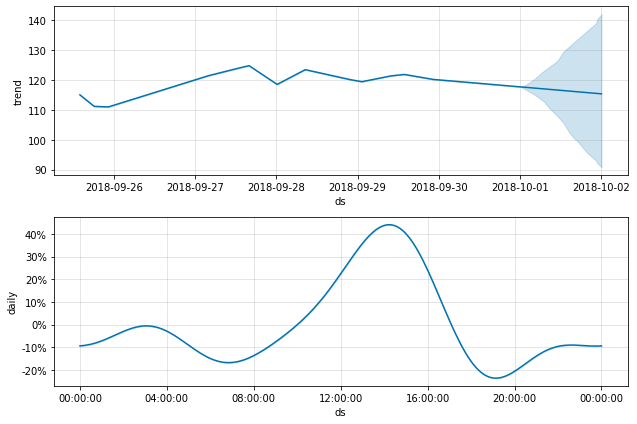

In [37]:
_ = model.plot_components(forecast)

In [38]:
plot_plotly(model, forecast, xlabel='czas', ylabel='ruch webowy')